The previous section dealt with parabolic equations like the heat equation, in which information traveled at infinite speed. In contrast, in a hyperbolic system, there is a fixed maximum speed at which information can travel. The simplest hyperbolic equation is the transport equation:
$$
    u_t + a u_x = 0,\\
    u(x, 0) = g(x)
$$
where $a$ is any constant (positive or negative) and $g$ specifies the initial conditions.

Using the principles from the last section, we can try to design a second-order scheme by using the centered difference to $u_x$:
$$
    \frac{U^{n+1}_i - U^n_i}{\Delta t} + a \frac{U^n_{i+1} - U^n_{i-1}}{2 \Delta x} = 0,\\
    U^{n+1}_i = \frac{r}{2} U^n_{j-1} + U^n_j - \frac{r}{2} U^n_{j+1},
$$
where $r = a \Delta t/\Delta x$. We can code this up quickly with $a = 1$, periodic boundary conditions on the interval $[0, 1]$, and some initial conditions:

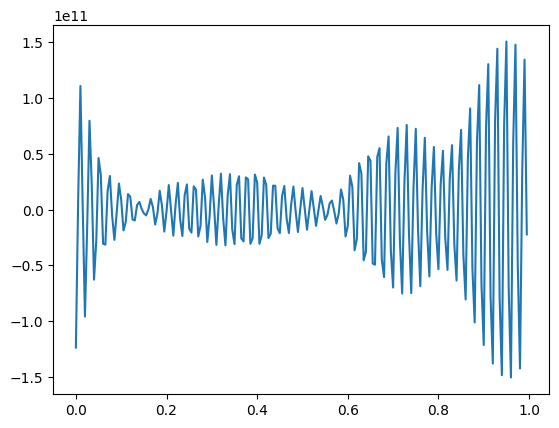

In [23]:
import numpy as np
import matplotlib.pyplot as plt

T = 1 # final time
J = 200 # J spacial points (not J+1 because we have periodic BCs)
N = 250 # N+1 time grid points
dx = 1/J
dt = 1/N
r = dt/dx
xvals = np.linspace(0, 1, num=J, endpoint=False)
U = np.sin(xvals*2*np.pi) # initial conditions

for i in range(N):
    U = r/2*np.roll(U, 1) + U - r/2*np.roll(U, -1)

plt.plot(xvals, U)

This is not at all what we had hoped for. The scheme is exhibiting numerical instability. This is even with extremely smooth initial conditions. As an experiment, see what happens for other step sizes. What if you use much more time steps? What if you change the initial conditions to be only continuous instead of smooth? Or discontinuous?

TODO: stability analysis

If we set $f(s) = u(x_0 + a s,t_0 + s)$ then 
$$
    df/ds = u_x(x_0+as, t_0+s)(a) + u_t(x_0+as,t_0+s) = 0.
$$
This tells us that $f$ is constant, and $f(s) = f(0)$. So $u(x_0 + a s,t_0 + s) = u(x_0, t_0)$. Finally, we can use $s = t_0$ to see that
$$
    u(x_0, t_0) = u(x_0 - a t_0, t_0 - t_0) = g(x_0 - a t_0).
$$
Thus, we have found the general solution $u(x, t) = g(x - at)$. 

All that the linear transport equation does is take the initial conditions and shift them over time, with a speed of $a$. For this reason, we can say that information travels with a finite speed, namely $a$. In the heat equation, we saw that a scheme which did not take into account global information did very poorly. In contrast, we expect that a scheme which takes into account only local information can be just fine, because all the information needed to propagate the solution forward is local.

With knowledge of the general solution in hand, the linear transport equation becomes trivial to solve numerically, but it will be a good testbed for schemes which may be extended to more difficult problems. We will find out that many schemes do not perform nearly as well as we would have hoped, especially if the initial conditions are not particularly nice.

One final thing to consider is where the information comes from. From the general solution $u(x, t) = g(x-at)$, we see that if we want to know the solution at a point $x_0$ slightly in the future, $u(x_0, 0.1) = u(x_0-0.1 a, 0)$. Thus, the solution at $x_0$ depends on the value of $u$ at $t=0$ slightly to the left of $x_0$ if $a$ is positive, or slightly to the right of $x_0$ if $a$ is negative. This motivates the definition of the *upwind* direction: the direction from which information comes from. If $a > 0$, the upwind direction is to the left (negative), and if $a < 0$, the upwind direction is to the right (positive).

We also see that the solution at $x_0$ at some time in the future is completely independent of what happens downwind of $x_0$. This, our schemes should reflect this physical reality. Let's design our first scheme, the *upwind scheme*.